In this mini-lecture we continue with discussions on word embeddings and we focus on the FastText algorithm.  We will, in this tutorial, use the stable version of Gensim 3.8.3. Currently Gensim is going through some big changes for versions above 4.0.1. The new version is more powerful but a bit unstable. So we will use the stable version in this tutorial. Details between version 4 and 3 are specified here:

   - https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4 

In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
import string
import nltk
import gensim 

from sklearn.decomposition import PCA
from collections import Counter, defaultdict
from gensim.models.fasttext import FastText

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

%matplotlib inline

In [6]:
# warnings.filterwarnings("ignore")

path="C:\\Users\\GAO\\python workspace\\GAO_Jupyter_Notebook\\Datasets"
os.chdir(path)

print("Gensim Version: ", gensim.__version__)
# path="C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\Introduction to Data Science Using Python\\datasets"
# os.chdir(path)

Gensim Version:  3.8.3


### I. Intuition of FastText

**Morphology** is simply the study of forms of words. Continuous word representations, trained on large unlabeled corpora are useful for many natural language processing tasks. Popular models that learn such representations ignore the morphology of words, by assigning a distinct vector to each word. This is a limitation, especially for languages with large vocabularies and many rare words.

FastText, proposed by Facebook researchers in 2017, is a a new approach based on the skip-gram model, where each word is represented as a bag of character n-grams. A vector representation is associated to each character n-gram. FastText can be implemented not just for the English language, but also for many other languages such as Spanish or French based on alphbabet. The motivation of FastText is that most of the traditional techniques represent each word of the vocabulary by a distinct vector, without parameter sharing. In particular, they ignore the internal structure of words, which is an important limitation for morphologically rich languages, such as Turkish or Finnish. For example, in French or Spanish, most verbs have more than 40 different inflected forms, while the Finnish language has fifteen cases for nouns. These languages contain many word forms that occur rarely in the training corpus, making it difficult to learn good word representations. Because many word formations follow rules, it is possible to improve vector representations for morphologically rich languages by using character-level information. Essentially, the FastText model considers each word as a bag of character n-grams (by breaking words or phrases into smaller chunks of alphabets).

In recent years, many methods have been proposed to incorporate morphological information into word representations. To model rare words better, for example,  Alexandrescu and Kirchhoff (2006) introduced factored neural language models, where words are represented as sets of features. These features might include morphological information, and this technique was succesfully applied to morphologically rich languages beyond English. 

Here is an heuristic example. Suppose we have a word "where" that need to be represented. And imagine we have a sliding window of size 3 that zooms in the word each time to get a substring of the word. FastText essentially breaks the word as the following part: \['wh', 'whe', 'her', 'ere', 're', 'where'\] (We also include the word "where" itself in the set of its n-grams). 

In practice, the original paper recommends in extracting all the n-grams for $n \ge 3$ and $n \le 6$. This is a very simple approach, and different sets of n-grams could be considered, for example taking all prefixes and suffixes. We typically associate a vector representation (embedding) to each n-gram for a word. Thus, we can represent a word by the sum of the vector representations of its n-grams or the average of the embedding of these n-grams. Thus, due to this effect of leveraging n-grams from individual words based on their characters, there is a higher chance for rare words to get a good representation since their character based n-grams should occur across other words of the corpus. 

### II. EDA for FastText

Let’s apply FastText on the Bible and look at our words of interest and their most similar words. There are many Bible corpora, each with a different structure. For example, the NLTK provides the standard King James Bible (with tokenized words and sentences):

In [11]:
nltk.download('gutenberg')
bible_sents = nltk.corpus.gutenberg.sents('bible-kjv.txt')
print(bible_sents[9220:9221])

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\GAO\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


[['And', 'the', 'LORD', 'opened', 'their', 'eyes', ',', 'and', 'they', 'saw', ';', 'and', ',', 'behold', ',', 'they', 'were', 'in', 'the', 'midst', 'of', 'Samaria', '.']]


However, this dataset only contains the plain texts that are pre-tokenized by words and sentences. It also contains verse indices that we do not want. Furhter, it doesn't allow us to subset the data based on different chapters. So let's use a different data source from Kaggle to extract the plain Bible text (see the 'bible' dataset below) as well as some other data enrichment (see the 'df_aux' dataset below). Details can be found here:

   - https://www.kaggle.com/oswinrh/bible/notebooks

In [12]:
bible = pd.read_csv('t_kjv.csv')
print("The number of rows for the plain Bible dataset: " + format(bible.shape[0]) + "; the number of columns: " + format(bible.shape[1]))

df_aux = pd.read_csv("BibleBooks.csv")
print("The number of rows for the enrichment dataset: " + format(df_aux.shape[0]) + "; the number of columns: " + format(df_aux.shape[1]))

The number of rows for the plain Bible dataset: 31103; the number of columns: 5
The number of rows for the enrichment dataset: 73; the number of columns: 7


In [13]:
print(bible.head(5))
print("------------------------------")
print(df_aux.head(5))

        id  b  c  v                                                  t
0  1001001  1  1  1  In the beginning God created the heaven and th...
1  1001002  1  1  2  And the earth was without form, and void; and ...
2  1001003  1  1  3  And God said, Let there be light: and there wa...
3  1001004  1  1  4  And God saw the light, that it was good: and G...
4  1001005  1  1  5  And God called the light Day, and the darkness...
------------------------------
           Book  Tanakh  King James Version  New Jerusalem Version  Time  \
0          Acts     NaN                44.0                     51    80   
1          Amos    17.0                30.0                     37  -745   
2        Baruch     NaN                 NaN                     32  -180   
3  1 Chronicles    38.0                13.0                     13  -350   
4  2 Chronicles    39.0                14.0                     14  -350   

        Period Location  
0    Christian     Rome  
1    Monarchic   Israel  
2  Helle

Now let's take a look at the column names and do a quick exploration. As we see, for the raw Bible dataset, the column 'b' indicates book indices (indices for Genesis, Exodus etc.):

In [14]:
bible['b'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
      dtype=int64)

A closer look at the data will make us realize the meaning of the columns of the data. For example, column 'b' indicates 'Book'. Column 'c' indicates 'Chapter', and column 'v' tells us verses.

So it looks like each verse is accessed by a unique key, or verse-ID, the combination of the book+chapter+verse. Here is an example:

   - Genesis 1:1 (Genesis chapter 1, verse 1) = 01001001 (01 001 001)
   - Exodus 2:3 (Exodus chapter 2, verse 3) = 02002003 (02 002 003)

The verse-ID system is used for faster, simplified queries. For instance, 01001001 - 02001005 would capture all verses between Genesis 1:1 through Exodus 1:5.  

Now let's enrich our dataset by combining the raw Bible data with another dataset that serves as an enrichment to the original dataset. We will also be adding a column to indicate whether it's New Testament or Old Testament:

In [15]:
bible.loc[bible['b'] <= 39, 'Testament'] = 'OT'
bible.loc[bible['b'] > 39, 'Testament'] = 'NT'

In [16]:
df_enriched = df_aux.drop(['Tanakh','New Jerusalem Version'], axis=1)
df_enriched['King James Version']=df_enriched['King James Version'].replace(np.nan, 0)
df_enriched['King James Version'] = df_enriched['King James Version'].astype('int')
df_enriched.sort_values(['King James Version']).head(15)

,Book,King James Version,Time,Period,Location
41,1 Maccabees,0,-150,Maccabean,Israel
2,Baruch,0,-180,Hellenistic,Israel
35,Judith,0,-125,Maccabean,Israel
70,Wisdom,0,-50,Maccabean,Israel
69,Tobit,0,-200,Hellenistic,Israel
42,2 Maccabees,0,-150,Maccabean,Israel
62,Sirach,0,-180,Hellenistic,Israel
17,Genesis,1,-500,Persian,Israel
13,Exodus,2,-500,Persian,Israel
39,Leviticus,3,-500,Persian,Israel


Notice that the Tobit and Judith etc. even precedes Genesis. Now let's merge the dataset (column 'b' in the raw Bible dataset is equivalent to the column 'King James Version' in the enrichment dataset):

In [17]:
df = bible.merge(df_enriched, left_on='b', right_on='King James Version')
df.head(3)

,id,b,c,v,t,Testament,Book,King James Version,Time,Period,Location
0,1001001,1,1,1,In the beginning God created the heaven and th...,OT,Genesis,1,-500,Persian,Israel
1,1001002,1,1,2,"And the earth was without form, and void; and ...",OT,Genesis,1,-500,Persian,Israel
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",OT,Genesis,1,-500,Persian,Israel


Finally let's rename some of the columns and create another column by making every verse in lower case. We will also create a field that indicates the text length (named 'NoWords').

In [18]:
df.rename(columns={'b': 'Book Index', 'c': 'Chapter Index', 'v': 'Verse', 't': 'Text'}, inplace=True)
df.drop(['King James Version'], axis=1, inplace=True)
df['NoWords'] = df['Text'].str.split().str.len() # number of words
df['text'] = df['Text'].str.lower()
df.head(5)

,id,Book Index,Chapter Index,Verse,Text,Testament,Book,Time,Period,Location,NoWords,text
0,1001001,1,1,1,In the beginning God created the heaven and th...,OT,Genesis,-500,Persian,Israel,10,in the beginning god created the heaven and th...
1,1001002,1,1,2,"And the earth was without form, and void; and ...",OT,Genesis,-500,Persian,Israel,29,"and the earth was without form, and void; and ..."
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",OT,Genesis,-500,Persian,Israel,11,"and god said, let there be light: and there wa..."
3,1001004,1,1,4,"And God saw the light, that it was good: and G...",OT,Genesis,-500,Persian,Israel,17,"and god saw the light, that it was good: and g..."
4,1001005,1,1,5,"And God called the light Day, and the darkness...",OT,Genesis,-500,Persian,Israel,22,"and god called the light day, and the darkness..."


Let's see some examplary verses. Notice that the way the texts are cut into verses are not strict by this corpus. And also notice that there are Shakespearean words such as "hath" and British way of writing "dwelt" (rather than "dwelled") in these text strings. Thus we need to clean and preprocess the data for the next step.

In [19]:
print(df.text[6739])
print(df.text[9876])
print(df.text[10005])
print(df.text[29270])

and he said unto jether his firstborn, up, and slay them. but the youth drew not his sword: for he feared, because he was yet a youth.
(and the lord gave israel a saviour, so that they went out from under the hand of the syrians: and the children of israel dwelt in their tents, as beforetime.
for the children of israel walked in all the sins of jeroboam which he did; they departed not from them;
and to know the love of christ, which passeth knowledge, that ye might be filled with all the fulness of god.


Below, the first function cleans the punctuations and special characters. We remove comma, period, colon, semicolon, and quotation marks. We also create a function that lemmatize the text. We then create a new field called "t_lem" after lemmatization. 

In [20]:
def clean_interpunction(data):
    values = data['text']
    values = values.replace('.','')
    values = values.replace(';','')
    values = values.replace(':','')
    values = values.replace(',','')
    values = values.replace("'","")
    values = values.replace('"','')
    data['text'] = values
    return data

def lem(a): # the argument must be a pandas Series object
    p = nltk.WordNetLemmatizer()
    b = []
    for line in a:

        split_line = line.split(' ')
        length=len(split_line)
        new_line = []

        for word in range(length):
            if word == 0:
                new_line.append(str(p.lemmatize(split_line[word], pos="v")))
            else:
                new_line[0] = new_line[0] + ' ' + (str(p.lemmatize(split_line[word], pos="v")))

        b.append(new_line[0])

    return b

In [24]:
df = df.apply(clean_interpunction, axis=1) # removing punctuations must happen prior to lemmatizing words
df['t_lem']=lem(df.text)

# print(df['t_lem'][30389]) # sanity check
# print(df['text'][30389]) # sanity check

A **verset** is defined as a short verse especially from a sacred book (say Bible). Now let's look at some visualization related to the count of versets and number of words:

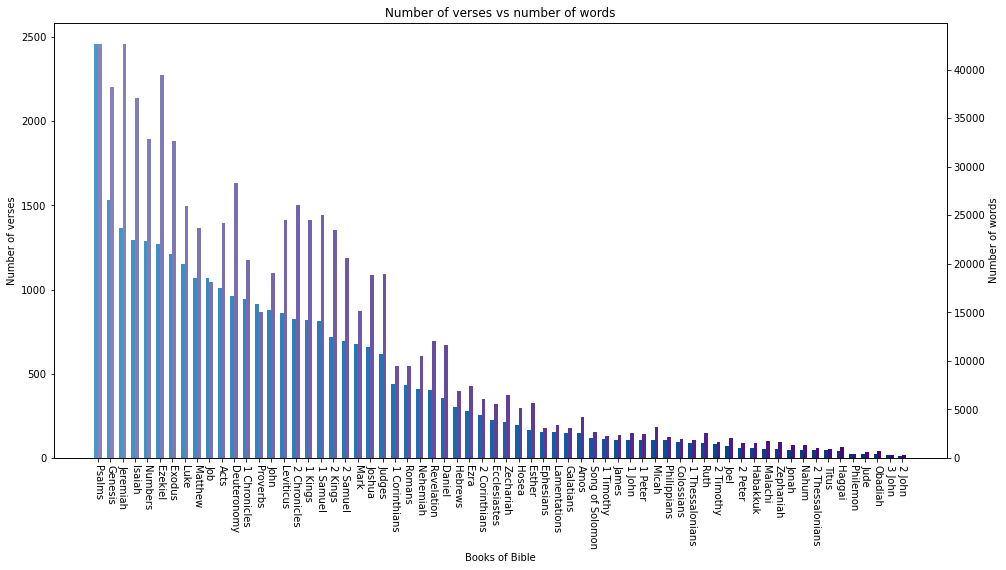

In [42]:
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

words_versets = df.groupby('Book').agg({'Book Index':'count','NoWords':'sum'}).sort_values(by='Book Index',ascending=False)
data1 = words_versets['Book Index']
data2 = words_versets['NoWords']

plt.figure(figsize=(16,8))
x = np.arange(66)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
color = color_2

plt.title('Number of verses vs number of words')
plt.xticks(x + w /2, data1.index, rotation=-90)
           
ax1.set_xlabel('Books of Bible')
ax1.set_ylabel('Number of verses')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx() # creating a twin axes sharing the x-axis
ax2.set_ylabel('Number of words')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

Now let's remove stopwords and additional punctuations and create a function that generates n-grams. Then we will look at word frequencies (unigrams and bigrams).

In [43]:
rm_stop_list = nltk.corpus.stopwords.words('english')
rm_stop_list.extend(["from", "upon", "away", "even", "unto", "thou", "shall", "shan't", "ye", 
           "thy", "thyself", "hath", "also", "you", "come", "came", "let", "one", "may"
           "thing", "things", "with", "without", "thereof", "therefore", "thus", "say", "saith",
            "many", "much", "son", "sons", "thee", "make", "shalt", "every", "thine", "thy", "hast", "&", "-"])

sw=rm_stop_list

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in sw]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

OldTestament = df[df.Testament == 'OT']
NewTestament = df[df.Testament == 'NT']

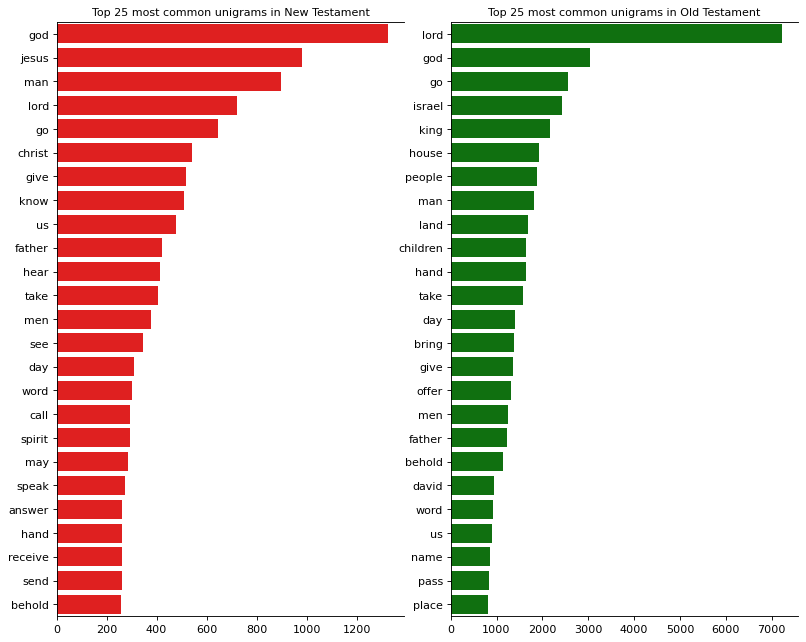

In [46]:
NT_unigrams = defaultdict(int) # New Testament
OT_unigrams = defaultdict(int) # Old Testament

for line in NewTestament['t_lem']:
    for word in generate_ngrams(line):
        NT_unigrams[word] += 1
        
for line in OldTestament['t_lem']:
    for word in generate_ngrams(line):
        OT_unigrams[word] += 1
        
df_NT_unigrams = pd.DataFrame(sorted(NT_unigrams.items(), key=lambda x: x[1])[::-1])
df_OT_unigrams = pd.DataFrame(sorted(OT_unigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(10, 8), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(y=df_NT_unigrams[0].values[:N], x=df_NT_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_OT_unigrams[0].values[:N], x=df_OT_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    
axes[0].set_title(f'Top {N} most common unigrams in New Testament', fontsize=10)
axes[1].set_title(f'Top {N} most common unigrams in Old Testament', fontsize=10)

plt.show()

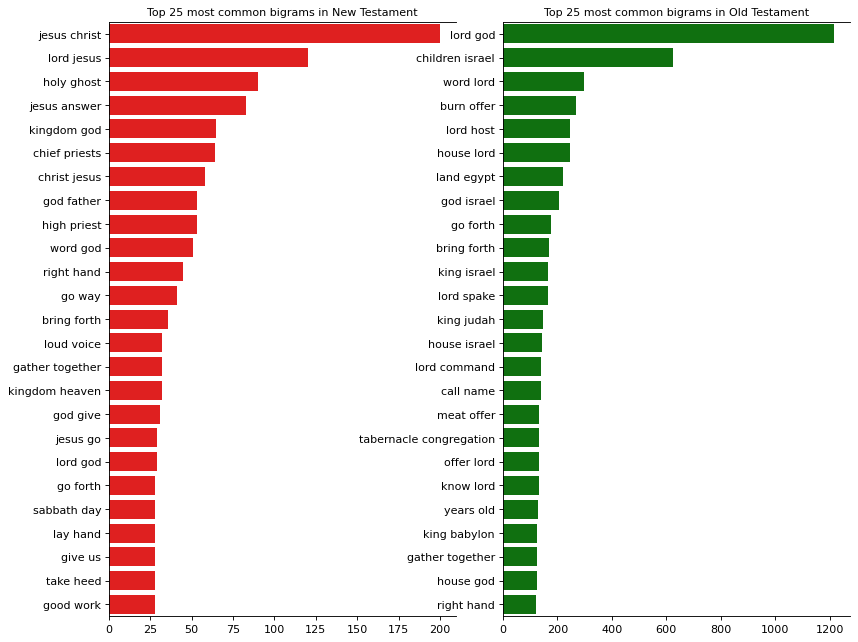

In [47]:
NT_bigrams = defaultdict(int)
OT_bigrams = defaultdict(int)

for line in NewTestament['t_lem']:
    for word in generate_ngrams(line, n_gram=2):
        NT_bigrams[word] += 1
        
for line in OldTestament['t_lem']:
    for word in generate_ngrams(line, n_gram=2):
        OT_bigrams[word] += 1
        
df_NT_bigrams = pd.DataFrame(sorted(NT_bigrams.items(), key=lambda x: x[1])[::-1])
df_OT_bigrams = pd.DataFrame(sorted(OT_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(10, 8), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(y=df_NT_bigrams[0].values[:N], x=df_NT_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_OT_bigrams[0].values[:N], x=df_OT_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

axes[0].set_title(f'Top {N} most common bigrams in New Testament', fontsize=10)
axes[1].set_title(f'Top {N} most common bigrams in Old Testament', fontsize=10)

plt.show()

Let's look at some wordclouds:

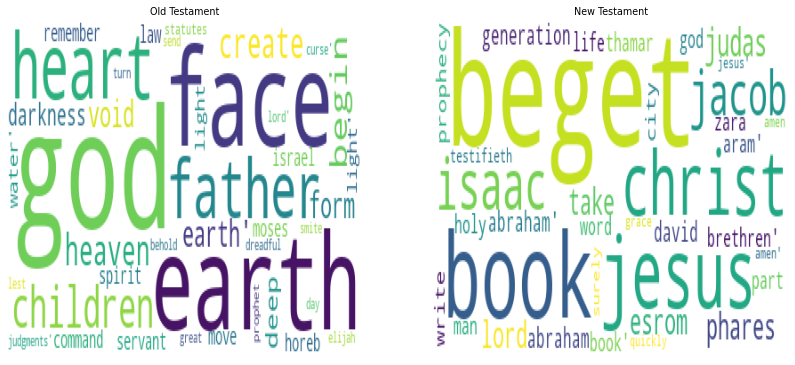

In [48]:
matplotlib.rcParams['figure.figsize']=(14,6)    
matplotlib.rcParams['font.size']=8                     
matplotlib.rcParams['figure.subplot.bottom']=0.1 

wordcloud_Old = WordCloud(background_color='white',stopwords=sw).generate(str(OldTestament.t_lem.values))
wordcloud_New = WordCloud(background_color='white',stopwords=sw).generate(str(NewTestament.t_lem.values))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax0, ax1 = ax.flatten()

ax0.imshow(wordcloud_Old, aspect="auto")
ax0.title.set_text('Old Testament')
ax0.axis('off')

ax1.imshow(wordcloud_New, aspect="auto")
ax1.title.set_text('New Testament')
ax1.axis('off')

plt.show()

Lexical diversity on each sentence tells us the diversity of word usage. Let's compute this score on each original verse and then look at the summary statistics and associated visualizations:

In [49]:
def wd_tokenize(text):
    tokens=word_tokenize(text)
    return tokens

df["word_tokens"]=df['text'].apply(wd_tokenize)
print(df["word_tokens"][0])

['in', 'the', 'beginning', 'god', 'created', 'the', 'heaven', 'and', 'the', 'earth']


In [50]:
def lexical_diversity(text):
    """
    The argument 'text' must be a list of tokens
    """
    return len(set(text)) / len(text)

df['lexical diversity']=df['word_tokens'].apply(lexical_diversity)

In [52]:
analysis1=df.groupby(['Book'])['lexical diversity'].aggregate([min, np.mean, np.median, max]) # the result is a 'DataFrame' object
analysis1.head(10)

,min,mean,median,max
Book,,,,
1 Chronicles,0.388889,0.752117,0.760952,1.0
1 Corinthians,0.434783,0.820135,0.833333,1.0
1 John,0.515152,0.786617,0.800000,1.0
1 Kings,0.366667,0.778524,0.776820,1.0
1 Peter,0.615385,0.861219,0.875000,1.0
1 Samuel,0.413793,0.792007,0.795455,1.0
1 Thessalonians,0.605263,0.885600,0.909091,1.0
1 Timothy,0.631579,0.896235,0.904762,1.0
2 Chronicles,0.375000,0.759206,0.764706,1.0


<AxesSubplot:xlabel='lexical diversity'>

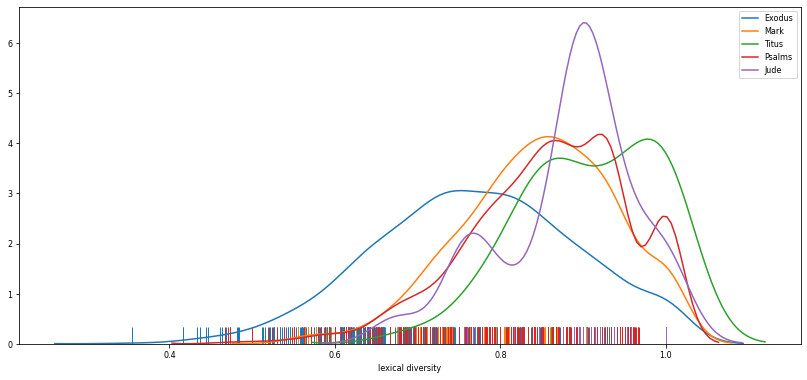

In [55]:
Exodus=df[df['Book']=='Exodus']['lexical diversity']
Mark=df[df['Book']=='Mark']['lexical diversity']
Titus=df[df['Book']=='Titus']['lexical diversity']
Psalms=df[df['Book']=='Psalms']['lexical diversity']
Jude=df[df['Book']=='Jude']['lexical diversity']

sns.distplot(Exodus, hist=False, rug=True, label='Exodus')
sns.distplot(Mark, hist=False, rug=True, label='Mark')
sns.distplot(Titus, hist=False, rug=True, label='Titus')
sns.distplot(Psalms, hist=False, rug=True, label='Psalms')
sns.distplot(Jude, hist=False, rug=True, label='Jude')

### III. Implementing FastText

According to some comparison of Word2Vec and FastText algorithm, it seems that FastText does significantly better on syntactic tasks as compared to the original Word2Vec model, especially when the size of the training corpus is small. Word2Vec slightly outperforms FastText on semantic tasks though. The differences grow smaller as the size of the training corpus increases. Nowadays, both models are well-received by the data science community, although FastText sounds more 'posh'. We now implement the FastText algorithm in Gensim. 

There is one benefit using FastText rather than Word2Vec model: FastText can obtain vectors even for out-of-vocabulary (OOV) words, by summing up vectors for its component character n-grams, provided at least one of the n-grams was present in the training data. If we do a similarity query in Gensim after training the Word2Vec model, we will see that if we plug in a word that the corpus has never seen before, it will trigger an error message. FastText doesn't have that type of problem. 

In [59]:
df.drop(['word_tokens'], axis=1, inplace=True)
df.head(2)

,id,Book Index,Chapter Index,Verse,Text,Testament,Book,Time,Period,Location,NoWords,text,t_lem,lexical diversity
0,1001001,1,1,1,In the beginning God created the heaven and th...,OT,Genesis,-500,Persian,Israel,10,in the beginning god created the heaven and th...,in the begin god create the heaven and the earth,0.800000
1,1001002,1,1,2,"And the earth was without form, and void; and ...",OT,Genesis,-500,Persian,Israel,29,and the earth was without form and void and da...,and the earth be without form and void and dar...,0.551724


Now let's implement the model by getting the correct format of the data. Here is what the final data should look like (see below). By declaring the text 'clean', we mean the sentence has removed all the stopwords, unnecessary punctuations, words with short length, and multiple spaces etc.:

In [58]:
ft_data_example=['beginning god create heaven earth',
 'earth form void darkness face deep', '...']
print(ft_data_example)

['beginning god create heaven earth', 'earth form void darkness face deep', '...']


Let's create a function to do all of the above:

In [60]:
def preprocess_text(document):
    
    p = WordNetLemmatizer()
    document = re.sub(r'\W', ' ', str(document)) # removing all special characters 
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document) # removing all single characters
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) # removing single characters from the start
    document = re.sub(r'\s+', ' ', document, flags=re.I) # substituting multiple spaces with single space
    document = re.sub(r'^b\s+', '', document) # removing prefixed 'b'
    document = document.lower()

    tokens = document.split()
    tokens = [p.lemmatize(word) for word in tokens] # lemmatization
    tokens = [word for word in tokens if word not in sw] # removing element of the list 'sw' which contains all stopwords
    tokens = [word for word in tokens if len(word) > 3] # removing only short words (word length <=3)

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [61]:
final_corpus = [preprocess_text(sentence) for sentence in df['Text'] if sentence.strip() !='']
print(final_corpus[0:3])

['beginning created heaven earth', 'earth form void darkness face deep spirit moved face water', 'said light light']


We have got the data in the format we need: a list of 'clean' sentence. Now let's tokenize the text:

In [67]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in final_corpus]
print(tokenized_corpus[9:12])

[['called', 'land', 'earth', 'gathering', 'together', 'water', 'called', 'good'], ['said', 'earth', 'bring', 'forth', 'grass', 'herb', 'yielding', 'seed', 'fruit', 'tree', 'yielding', 'fruit', 'kind', 'whose', 'seed', 'earth'], ['earth', 'brought', 'forth', 'grass', 'herb', 'yielding', 'seed', 'kind', 'tree', 'yielding', 'fruit', 'whose', 'seed', 'kind', 'good']]


Now let's run the model. FastText supports the following parameters from the original Word2Vec model:

   - _model_: training architecture
   - _vector\_size_: dimensionality of vector embeddings to be learnt (default 100)
   - _alpha_: initial learning rate (default 0.025)
   - _window_: context window size (default 5)
   - _min\_count_: ignore words with number of occurrences below this (default 5)
   - _loss_: training objective; allowed values: ns, hs, softmax (default ns)
   - _sample_: threshold for downsampling higher-frequency words (default 0.001)
   - _negative_: number of negative words to sample, for ns (default 5)
   - _epochs_: number of epochs (default 5)
   - _sorted\_vocab_: sort vocab by descending frequency (default 1)
   - _threads_: number of threads to use (default 12)
   
In addition, fastText has three additional parameters:

   - _min\_n_: min length of char n-grams (default 3)
   - _max\_n_: max length of char n-grams (default 6)
   - _bucket_: number of buckets used for hashing n-grams (default 2000000)

Parameters _min\_n_ and _max\_n_ control the lengths of character n-grams that each word is broken down into while training and looking up embeddings. If _max\_n_=0, or to be lesser than _min\_n_, no character n-grams are used, and the model effectively reduces to the Word2Vec model.

In [68]:
feature_size = 100   # word vector dimensionality  
window_context = 50  # context window size                                                                                    
min_word_count = 5   # minimum word count                        
sample = 1e-3   # downsample setting for frequent words

# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = gensim.models.fasttext.FastText(tokenized_corpus, 
                                           size=feature_size, 
                                           window=window_context, 
                                           min_count=min_word_count,
                                           sample=sample, 
                                           sg=1, iter=50)

All information necessary for looking up fastText words (incl. OOV words) is contained in its "model.wv" attribute. Remember that FastText models support vector lookups for out-of-vocabulary words by summing up character n-grams belonging to the word.

If we don’t need to continue training our model, we can export and save this model attribute and discard model, to save space and RAM:

In [69]:
wv = ft_model.wv
print(wv)
print(wv['night'])

[ 0.10219321  0.232341    0.17232402 -0.16375533  0.3321181   0.04213899
  0.4311662   0.24716377 -0.35556445 -0.38953283 -0.18542367 -0.06442591
  0.21983552 -0.3041166   0.50554496  0.05530559  0.05984487 -0.6379594
 -0.15579537 -0.06355559  0.40978077  0.03884847  0.08333874 -0.39478964
  0.0429376  -0.09200189 -0.31238893 -0.05602849 -0.7268282   0.3852485
  0.1600128   0.19675075 -0.150536    0.09981468  0.42236224 -0.1285421
  0.03113003  0.3069821  -0.09465416 -0.08263659 -0.36376658 -0.10756501
 -0.11486205  0.02331524  0.04783876  0.22465396  0.216724    0.18226607
 -0.07022873 -0.01522344 -0.15610048 -0.08075441  0.03351042  0.14713377
  0.11379234 -0.681547   -0.12068076  0.154026   -0.04830667 -0.6793894
  0.03055685  0.05174353 -0.26088485  0.11282115  0.1045233  -0.127885
 -0.21130317  0.023949    0.17480977  0.15285447 -0.19044985  0.03197538
 -0.12197778  0.1795279   0.14344831 -0.13579822  0.28370857 -0.002772
 -0.02681559  0.06471514  0.23132004  0.15301785  0.502158 

In [70]:
print(wv.similarity("moses", "aaron"))
print(wv.similarity("jesus", "christ"))
print(wv.similarity("angel", "demon"))

0.77352595
0.77362907
0.2760766


In [71]:
print(wv.most_similar("nights"), "\n")
print(wv.most_similar("abraham"), "\n")
print(wv.most_similar("mercy"), "\n")
print(wv.most_similar("faith"), "\n")
print(wv.most_similar("angel"), "\n")

[('night', 0.8068452477455139), ('dawning', 0.5176382064819336), ('hawk', 0.50697922706604), ('hour', 0.5049279928207397), ('brightness', 0.5010610222816467), ('morning', 0.4911341071128845), ('shining', 0.48830878734588623), ('sighing', 0.48816215991973877), ('thunderings', 0.48810824751853943), ('lightning', 0.48428577184677124)] 

[('isaac', 0.8580623865127563), ('sarah', 0.7391049861907959), ('terah', 0.603269100189209), ('saidst', 0.536972165107727), ('hagar', 0.5322883725166321), ('seed', 0.5265136361122131), ('swarest', 0.5239028930664062), ('machpelah', 0.5224916338920593), ('rebekah', 0.5214452147483826), ('sarai', 0.5201493501663208)] 

[('endureth', 0.6082525253295898), ('merciful', 0.6002879738807678), ('lovingkindness', 0.5758606195449829), ('gracious', 0.5699398517608643), ('salvation', 0.524529218673706), ('truth', 0.5001931190490723), ('forsaketh', 0.49071425199508667), ('endure', 0.487833172082901), ('lord', 0.47812628746032715), ('kindness', 0.4756883382797241)] 

[('

#### References:
   - https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
   - https://arxiv.org/abs/1607.04606 
   - https://www.kaggle.com/oswinrh/bible/notebooks
   - https://www.kaggle.com/jjmewtw/total-bible-text-study-eda-cluster-bert-nlp 
   - https://www.kaggle.com/jjmewtw/total-bible-text-study-eda-cluster-bert-nlp/data?select=BibleBooks.csv
   - https://stackabuse.com/python-for-nlp-working-with-facebook-fasttext-library/
   - https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4 
   - Andrei Alexandrescu and Katrin Kirchhoff (2006). "Factored neural language models". In Proc. NAACL.